CFE Data Assimilation of USGS streamflow data. Synthetic Forcing Data example to test methodology and 1-18 hour forecast. 

In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta

sys.path.insert(0, './CFE')
#import bmi_cfe_originial
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


(750.0, 780.0)

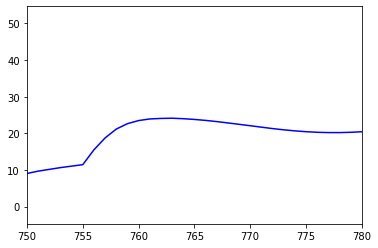

In [2]:
# Get Synthetic Observations (USGS)
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')

# Open forcing file
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
# Make empty list to plot
OBSERVATIONS_LIST = []

# Loop through precipitation in forcing data to set values
for i, precip in enumerate(df_forcing['APCP_surface_0']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    # Get streamflow based on sin wave to see variation in synthetic observed streamflow
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)

cfe_obs.finalize()

# See plot to make sure it works
plt.plot(OBSERVATIONS_LIST,color = 'blue')
plt.xlim(750,780)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

Final Framework for running each synthetic CFE model, EnKF DA, and synthetic observations

In [4]:
#Make empty matrices for plotting
cfeOpen_ensa    = []
cfeAnalysis_ens = []

## Loop through n different precipitation files for forcing. Max is 100 from forcing data
n_loop = 2
for loop in range(n_loop):
    p = 'APCP_surface_' + str(loop) #set p to each synthetic forcing data
    
    # Make empty matrices for plotting
    cfeOpen = []
    cfePeturbed = []
    cfeAnalysis = []
    cfeEnKF = []
    
    # Initialize Case study files
    cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json')
    
    ## Loop through time. Set values for each model and get values
    for i, precip in enumerate(df_forcing[str(p)]):

        # Set values for each CFE model. Adding precipitation since we are using an uncalibrated model to see flow result
        cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3) #value of precip from forcing data in loop
        cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        
        # Update usgs data and get value to put into EnKF
        obs = OBSERVATIONS_LIST[i]
        enkf.set_value('validity', 1)

        # set observations to plot without EnKF for future forecast
        if i>=768:
            enkf.set_value('validity', 0)

        # Update CFE open and peturbed. Get value for peturbed stats. 
        cfe_open.update()
        cfe_peturbed.update()
        
        # Get state variable originial values from CFE Peturbed to update in EnKF
        soil_storage_avail             = cfe_peturbed.get_value('soil_storage_avail_m')
        soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
        storage_max_m                  = cfe_peturbed.get_value("storage_max_out_m")
        surface_runoff                 = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')

        # Set outflow for CFE Open and CFE Peturbed to plot
        outflow        = cfe_open.get_value('land_surface_water__runoff_depth')
        cfeOpen.append(outflow) #for plotting
        
        # Get mean and covariance of CFE Peturbed outflor of ensemble runs for EnKF
        outflow_peturb       = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
        outflow_peturb_mean  = np.mean(outflow_peturb)
        outflow_peturb_covar = np.cov(outflow_peturb)
        cfePeturbed.append(outflow_peturb_mean) # For plotting

        # Set EnKF state variable values to state variables from CFE Petubred
        enkf.set_value('soil_storage_avail_m', soil_storage_avail) 
        enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) 
        enkf.set_value('surface_runoff_depth_m', surface_runoff)
        enkf.set_value('storage_max_m',storage_max_m)

        # Set EnkF values usgs, mean, and covariance (from CFE Peturbed)
        enkf.set_value('x', np.array([outflow_peturb_mean]))
        enkf.set_value('P', np.array([outflow_peturb_covar]))
        enkf.set_value('z', np.array([obs]))
        #enkf_validity=enkf.set_value('validity',validity) #check validity if needed
        enkf.update()
        
        # For plotting if needed
        outflow_enkf = enkf.get_value('enkf')
        cfeEnKF.append(outflow_enkf)
        
        # Get updated state variable values from EnKF to pass into CFE Analysis
        state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
        state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
        # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
        state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

        # Set CFE analysis state variable changes from EnKF to get final true streamflow values
        cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) 
        cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) 
        cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
        cfe_analysis.update() #get new streamflow value based on state var change
        
        # For plotting CFE Analysis from newly updated state variables. FINAL MODEL! 
        outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
        cfeAnalysis.append(outflow_analysis) 

        # Get CFE Analysis state variables to then pass back into CFE Peturbed 
        cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
        cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
        cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

        # Set updated state variables into CFE Peturbed for the loop of updating state variables to continue! 
        cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
        cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
        cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)

    # Append models results from last hour of data assimilation for the 18 hour forecast
    cfeOpen_ensa.append(np.divide(abs(np.subtract(cfeOpen[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    cfeAnalysis_ens.append(np.divide(abs(np.subtract(cfeAnalysis[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    
    # Get mean of each hour in 18hour forecast
    cfeOpen_ensa_mean=np.mean(cfeOpen_ensa,axis=0)
    cfeanalysis_ensa_mean=np.mean(cfeAnalysis_ens,axis=0)
    
# Finalize the models!  
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()


initialized 10
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [9.61467379]
surface_runoff_ratio [2.16166509]
Leftover vol 0.0
surface _runoff [2.16166509]
***********over estimaiton ratio [1.]
Observation BMI [9.14803171]
CFE [22.16565055]
enkf [9.61467379]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2957114578598735
EnKF Code predicted, X Post [16.39634852]
surface_runoff_ratio [1.53000377]
Leftover vol [25.02056969]
surface _runoff [1.53000377]
***********over estimaiton ratio [0.39588529]
Observation BMI [16.75252741]
CFE [41.41691821]
enkf [16.39634852]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28072802840953426
EnKF Code predicted, X Post [22.57536887]
surface_runoff_ratio [1.61592727]
Leftover vol [30.56176262]
surface _runoff [1.61592727]
***********over estimaiton ratio [0.4248511]
Observation BMI [22.40183725]
CFE [53.137131

Leftover vol 0.0
surface _runoff [0.26886367]
***********over estimaiton ratio [1.]
Observation BMI [2.92985482]
CFE [4.39914967]
enkf [3.37908337]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16074573073185794
EnKF Code predicted, X Post [2.09968057]
***********under estimaiton ratio [1.16922074]
Observation BMI [2.19477017]
CFE [1.79579483]
enkf [2.09968057]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16874301094255306
EnKF Code predicted, X Post [0.93516036]
***********under estimaiton ratio [1.05500023]
Observation BMI [1.6166818]
CFE [0.88640773]
enkf [0.93516036]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17661029940438366
EnKF Code predicted, X Post [0.96181918]
***********under estimaiton ratio [2.50944027]
Observation BMI [1.12415109]
CFE [0.38328036]
enkf [0.96181918]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1843497090675439
En

EnKF Code predicted, X Post [6.1716367]
surface_runoff_ratio [1.86565076]
Leftover vol 0.0
surface _runoff [1.86565076]
***********over estimaiton ratio [1.]
Observation BMI [5.94462439]
CFE [14.8344965]
enkf [6.1716367]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.24157728640484044
EnKF Code predicted, X Post [5.8939478]
surface_runoff_ratio [0.45015848]
Leftover vol [19.30610298]
surface _runoff [0.45015848]
***********over estimaiton ratio [0.23388635]
Observation BMI [6.1374085]
CFE [25.20005078]
enkf [5.8939478]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.23129970397039668
EnKF Code predicted, X Post [7.00911447]
surface_runoff_ratio [1.44823566]
Leftover vol 0.0
surface _runoff [1.44823566]
***********over estimaiton ratio [1.]
Observation BMI [6.24429498]
CFE [19.73519822]
enkf [7.00911447]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22190943729654544
EnKF Code predicted

EnKF Code predicted, X Post [1.25727258]
surface_runoff_ratio [0.13036795]
Leftover vol 0.0
surface _runoff [0.13036795]
***********over estimaiton ratio [1.]
Observation BMI [0.87630582]
CFE [1.99964959]
enkf [1.25727258]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17620263810125403
EnKF Code predicted, X Post [1.1240621]
***********under estimaiton ratio [1.12243271]
Observation BMI [0.60940754]
CFE [1.00145166]
enkf [1.1240621]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18394867409290871
EnKF Code predicted, X Post [0.66362331]
***********under estimaiton ratio [2.75134056]
Observation BMI [0.67354686]
CFE [0.24119999]
enkf [0.66362331]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19156880218352768
EnKF Code predicted, X Post [0.31211139]
***********under estimaiton ratio [1.83926725]
Observation BMI [0.94210142]
CFE [0.16969333]
enkf [0.31211139]
Beginning-----------------

EnKF Code predicted, X Post [17.01728485]
surface_runoff_ratio [1.9483561]
Leftover vol 0.0
surface _runoff [1.9483561]
***********over estimaiton ratio [1.]
Observation BMI [17.58320897]
CFE [19.58534767]
enkf [17.01728485]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2053177320143702
EnKF Code predicted, X Post [17.13059162]
surface_runoff_ratio [2.69957656]
Leftover vol 0.0
surface _runoff [2.69957656]
***********over estimaiton ratio [1.]
Observation BMI [17.21567929]
CFE [32.74159122]
enkf [17.13059162]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19815939287183737
EnKF Code predicted, X Post [16.9332894]
surface_runoff_ratio [1.24223068]
Leftover vol [26.59081105]
surface _runoff [1.24223068]
***********over estimaiton ratio [0.38905547]
Observation BMI [16.82517796]
CFE [43.52410045]
enkf [16.9332894]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1916201498243969
EnKF Code 

EnKF Code predicted, X Post [-0.9673347]
surface_runoff_ratio [0.00158639]
Leftover vol 0.0
surface _runoff [0.00158639]
***********over estimaiton ratio [1.]
Observation BMI [-1.79991324]
CFE [0.01912808]
enkf [-0.9673347]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.20637928630842517
EnKF Code predicted, X Post [-1.53629895]
surface_runoff_ratio [0.00158755]
Leftover vol 0.0
surface _runoff [0.00158755]
***********over estimaiton ratio [1.]
Observation BMI [-1.92832736]
CFE [0.0243045]
enkf [-1.53629895]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.21363481613148616
EnKF Code predicted, X Post [-1.21533907]
surface_runoff_ratio [0.00158858]
Leftover vol 0.0
surface _runoff [0.00158858]
***********over estimaiton ratio [1.]
Observation BMI [-1.97906269]
CFE [0.01693305]
enkf [-1.21533907]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22077241098343336
EnKF Code predicted, X Post 

EnKF Code predicted, X Post [26.28263871]
surface_runoff_ratio [1.85174186]
Leftover vol [24.18094406]
surface _runoff [1.85174186]
***********over estimaiton ratio [0.52082387]
Observation BMI [25.82181884]
CFE [50.46358277]
enkf [26.28263871]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19156961788564197
EnKF Code predicted, X Post [26.43316561]
surface_runoff_ratio [1.97047327]
Leftover vol [17.56918403]
surface _runoff [1.97047327]
***********over estimaiton ratio [0.60072168]
Observation BMI [26.16675997]
CFE [44.00234964]
enkf [26.43316561]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18559690921040983
EnKF Code predicted, X Post [26.4137751]
surface_runoff_ratio [2.00847864]
Leftover vol [16.93867472]
surface _runoff [2.00847864]
***********over estimaiton ratio [0.60927987]
Observation BMI [26.46425205]
CFE [43.35244981]
enkf [26.4137751]
Beginning----------------------------
self.f 1.0
soil_storage_deficit

soil_storage_deficit_from CFE 0.1716796602773093
EnKF Code predicted, X Post [51.05282412]
surface_runoff_ratio [3.93870052]
Leftover vol [35.13387425]
surface _runoff [3.93870052]
***********over estimaiton ratio [0.59235155]
Observation BMI [50.52111731]
CFE [86.18669838]
enkf [51.05282412]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1674253056870053
EnKF Code predicted, X Post [50.21594828]
surface_runoff_ratio [4.32807146]
Leftover vol [27.64711456]
surface _runoff [4.32807146]
***********over estimaiton ratio [0.64492644]
Observation BMI [50.12869143]
CFE [77.86306284]
enkf [50.21594828]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16353923796034064
EnKF Code predicted, X Post [49.75190485]
surface_runoff_ratio [3.82650501]
Leftover vol [41.37829138]
surface _runoff [3.82650501]
***********over estimaiton ratio [0.54594313]
Observation BMI [49.73040475]
CFE [91.13019623]
enkf [49.75190485]
Beginning----------

EnKF Code predicted, X Post [12.72750607]
surface_runoff_ratio [0.80162251]
Leftover vol [38.19262471]
surface _runoff [0.80162251]
***********over estimaiton ratio [0.24995038]
Observation BMI [13.19121849]
CFE [50.92013079]
enkf [12.72750607]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3371883068126629
EnKF Code predicted, X Post [14.22741988]
surface_runoff_ratio [2.43024602]
Leftover vol 0.0
surface _runoff [2.43024602]
***********over estimaiton ratio [1.]
Observation BMI [13.73155737]
CFE [34.08046834]
enkf [14.22741988]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3186364536037989
EnKF Code predicted, X Post [14.63694324]
surface_runoff_ratio [2.63506987]
Leftover vol 0.0
surface _runoff [2.63506987]
***********over estimaiton ratio [1.]
Observation BMI [14.2700322]
CFE [31.18815063]
enkf [14.63694324]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3016870947137881
EnKF Cod

EnKF Code predicted, X Post [0.7701698]
***********under estimaiton ratio [57.51532921]
Observation BMI [1.56929644]
CFE [0.01339069]
enkf [0.7701698]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3394039995171112
EnKF Code predicted, X Post [0.90919896]
***********under estimaiton ratio [46.83548371]
Observation BMI [1.28780344]
CFE [0.01941261]
enkf [0.90919896]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3444972798432664
EnKF Code predicted, X Post [0.39903082]
***********under estimaiton ratio [24.57002913]
Observation BMI [0.95564686]
CFE [0.01624055]
enkf [0.39903082]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.34950777147131284
EnKF Code predicted, X Post [0.69888637]
***********under estimaiton ratio [37.71838587]
Observation BMI [0.58606881]
CFE [0.01852906]
enkf [0.69888637]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.35443682008970

EnKF Code predicted, X Post [12.02593976]
surface_runoff_ratio [2.61708226]
Leftover vol 0.0
surface _runoff [2.61708226]
***********over estimaiton ratio [1.]
Observation BMI [11.05608614]
CFE [27.94142993]
enkf [12.02593976]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.31641655035704797
EnKF Code predicted, X Post [11.88035027]
surface_runoff_ratio [0.80952618]
Leftover vol [26.53191403]
surface _runoff [0.80952618]
***********over estimaiton ratio [0.30928534]
Observation BMI [11.45738926]
CFE [38.4122643]
enkf [11.88035027]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.29966732535993434
EnKF Code predicted, X Post [15.05496319]
surface_runoff_ratio [2.2887396]
Leftover vol 0.0
surface _runoff [2.2887396]
***********over estimaiton ratio [1.]
Observation BMI [15.50884448]
CFE [28.87450366]
enkf [15.05496319]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.284345475892271
EnKF Code

EnKF Code predicted, X Post [0.65199087]
surface_runoff_ratio [0.66909217]
Leftover vol 0.0
surface _runoff [0.66909217]
***********over estimaiton ratio [1.]
Observation BMI [-0.16020969]
CFE [6.73630631]
enkf [0.65199087]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.13305933054488406
EnKF Code predicted, X Post [0.67102179]
surface_runoff_ratio [0.05705887]
Leftover vol [14.43146565]
surface _runoff [0.05705887]
***********over estimaiton ratio [0.04443121]
Observation BMI [0.23928924]
CFE [15.10248743]
enkf [0.67102179]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.13215380746358318
EnKF Code predicted, X Post [1.50895674]
surface_runoff_ratio [0.11617213]
Leftover vol [10.56550254]
surface _runoff [0.11617213]
***********over estimaiton ratio [0.12497096]
Observation BMI [0.629494]
CFE [12.07445928]
enkf [1.50895674]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.131337789294639

EnKF Code predicted, X Post [7.88181494]
surface_runoff_ratio [0.63092934]
Leftover vol [9.97725685]
surface _runoff [0.63092934]
***********over estimaiton ratio [0.44133396]
Observation BMI [7.49292225]
CFE [17.8590718]
enkf [7.88181494]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12295399634201143
EnKF Code predicted, X Post [7.43343877]
surface_runoff_ratio [1.50987441]
Leftover vol 0.0
surface _runoff [1.50987441]
***********over estimaiton ratio [1.]
Observation BMI [7.3846982]
CFE [14.89288817]
enkf [7.43343877]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12292065898034232
EnKF Code predicted, X Post [8.83073551]
surface_runoff_ratio [0.55664855]
Leftover vol [16.64134504]
surface _runoff [0.55664855]
***********over estimaiton ratio [0.34668293]
Observation BMI [7.20225426]
CFE [25.47208055]
enkf [8.83073551]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1228956571022342

EnKF Code predicted, X Post [-0.19998448]
surface_runoff_ratio [0.43735119]
Leftover vol 0.0
surface _runoff [0.43735119]
***********over estimaiton ratio [1.]
Observation BMI [-1.17878396]
CFE [5.06359252]
enkf [-0.19998448]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12269117378436922
EnKF Code predicted, X Post [-0.42843503]
surface_runoff_ratio [-0.03938209]
Leftover vol [15.14944978]
surface _runoff [-0.03938209]
***********over estimaiton ratio [-0.02910363]
Observation BMI [-1.47298295]
CFE [14.72101474]
enkf [-0.42843503]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226814637567355
EnKF Code predicted, X Post [-1.15207663]
surface_runoff_ratio [-0.10208122]
Leftover vol [11.94682263]
surface _runoff [-0.10208122]
***********over estimaiton ratio [-0.10672568]
Observation BMI [-1.7076792]
CFE [10.79474601]
enkf [-1.15207663]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1

surface _runoff [0.19229876]
***********over estimaiton ratio [0.13394755]
Observation BMI [2.01785347]
CFE [20.04872916]
enkf [2.68547819]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12270282370129737
EnKF Code predicted, X Post [2.14692726]
surface_runoff_ratio [0.15342172]
Leftover vol [12.0300382]
surface _runoff [0.15342172]
***********over estimaiton ratio [0.15143772]
Observation BMI [1.95940802]
CFE [14.17696546]
enkf [2.14692726]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12273174600063685
EnKF Code predicted, X Post [2.10738386]
surface_runoff_ratio [0.68386689]
Leftover vol 0.0
surface _runoff [0.68386689]
***********over estimaiton ratio [1.]
Observation BMI [1.82364442]
CFE [10.39034046]
enkf [2.10738386]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12272106455959941
EnKF Code predicted, X Post [2.313143]
surface_runoff_ratio [1.1114417]
Leftover vol 0.0
surface _

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12269755734403265
EnKF Code predicted, X Post [15.12187348]
surface_runoff_ratio [1.60465932]
Leftover vol [15.0800402]
surface _runoff [1.60465932]
***********over estimaiton ratio [0.50069256]
Observation BMI [15.673098]
CFE [30.20191369]
enkf [15.12187348]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12268439024802824
EnKF Code predicted, X Post [15.80839555]
surface_runoff_ratio [1.5316915]
Leftover vol [18.205706]
surface _runoff [1.5316915]
***********over estimaiton ratio [0.46476005]
Observation BMI [15.34686651]
CFE [34.01410156]
enkf [15.80839555]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12267267598771936
EnKF Code predicted, X Post [14.94875206]
surface_runoff_ratio [1.08472813]
Leftover vol [25.31116596]
surface _runoff [1.08472813]
***********over estimaiton ratio [0.37130607]
Observation BMI [15.07249644]
CFE [40.2599

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12267507982468862
EnKF Code predicted, X Post [0.55192453]
surface_runoff_ratio [0.04712199]
Leftover vol [14.32575421]
surface _runoff [0.04712199]
***********over estimaiton ratio [0.03709749]
Observation BMI [0.42102136]
CFE [14.87767873]
enkf [0.55192453]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12266791447504788
EnKF Code predicted, X Post [1.28182651]
surface_runoff_ratio [0.10315815]
Leftover vol [10.34041099]
surface _runoff [0.10315815]
***********over estimaiton ratio [0.11029085]
Observation BMI [0.80229774]
CFE [11.6222375]
enkf [1.28182651]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12267539122282656
EnKF Code predicted, X Post [1.84788966]
surface_runoff_ratio [0.62541526]
Leftover vol 0.0
surface _runoff [0.62541526]
***********over estimaiton ratio [1.]
Observation BMI [1.15239104]
CFE [10.65005713]
enkf [1.847889

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12273516074017765
EnKF Code predicted, X Post [-0.61494718]
surface_runoff_ratio [-0.04459172]
Leftover vol [19.41461825]
surface _runoff [-0.04459172]
***********over estimaiton ratio [-0.03271053]
Observation BMI [-1.38210493]
CFE [18.79967107]
enkf [-0.61494718]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12272121204118625
EnKF Code predicted, X Post [-2.03159582]
surface_runoff_ratio [-0.13121187]
Leftover vol [17.36606598]
surface _runoff [-0.13121187]
***********over estimaiton ratio [-0.13248556]
Observation BMI [-1.63748089]
CFE [15.33447016]
enkf [-2.03159582]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12271230697590285
EnKF Code predicted, X Post [-0.73829524]
surface_runoff_ratio [-0.04437364]
Leftover vol [10.71143951]
surface _runoff [-0.04437364]
***********over estimaiton ratio [-0.07402833]
Observation BMI [-1.826774

EnKF Code predicted, X Post [-1.59998974]
surface_runoff_ratio [-0.13129346]
Leftover vol [18.50357663]
surface _runoff [-0.13129346]
***********over estimaiton ratio [-0.09465386]
Observation BMI [-1.97907557]
CFE [16.90358689]
enkf [-1.59998974]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12282684196151794
EnKF Code predicted, X Post [-1.05769386]
surface_runoff_ratio [-0.11022053]
Leftover vol [10.39616786]
surface _runoff [-0.11022053]
***********over estimaiton ratio [-0.11326196]
Observation BMI [-1.92349112]
CFE [9.338474]
enkf [-1.05769386]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12280995884610024
EnKF Code predicted, X Post [1.7908826]
surface_runoff_ratio [0.56924091]
Leftover vol 0.0
surface _runoff [0.56924091]
***********over estimaiton ratio [1.]
Observation BMI [-1.79045771]
CFE [6.66471576]
enkf [1.7908826]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.122790

EnKF Code predicted, X Post [-0.98832915]
surface_runoff_ratio [-0.10475993]
Leftover vol [12.82653397]
surface _runoff [-0.10475993]
***********over estimaiton ratio [-0.0834864]
Observation BMI [-0.93624]
CFE [11.83820482]
enkf [-0.98832915]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12285996464698001
EnKF Code predicted, X Post [0.75462041]
surface_runoff_ratio [0.76947767]
Leftover vol 0.0
surface _runoff [0.76947767]
***********over estimaiton ratio [1.]
Observation BMI [-0.56807915]
CFE [9.17637148]
enkf [0.75462041]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12283539150728351
EnKF Code predicted, X Post [0.17010251]
surface_runoff_ratio [0.01551949]
Leftover vol [13.8475369]
surface _runoff [0.01551949]
***********over estimaiton ratio [0.01213489]
Observation BMI [-0.17656091]
CFE [14.01763941]
enkf [0.17010251]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12281444879

EnKF Code predicted, X Post [-0.86546818]
surface_runoff_ratio [-0.05806457]
Leftover vol [19.2114725]
surface _runoff [-0.05806457]
***********over estimaiton ratio [-0.04717475]
Observation BMI [-1.97656213]
CFE [18.34600432]
enkf [-0.86546818]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12263992428411685
EnKF Code predicted, X Post [-2.21207984]
surface_runoff_ratio [-0.17448341]
Leftover vol [13.00868816]
surface _runoff [-0.17448341]
***********over estimaiton ratio [-0.20488655]
Observation BMI [-1.97369621]
CFE [10.79660832]
enkf [-2.21207984]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226339169099655
EnKF Code predicted, X Post [0.6218269]
surface_runoff_ratio [0.42364106]
Leftover vol 0.0
surface _runoff [0.42364106]
***********over estimaiton ratio [1.]
Observation BMI [-1.89155342]
CFE [4.83333503]
enkf [0.6218269]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12263

Observation BMI [-1.45920811]
CFE [1.27966501]
enkf [-0.37531691]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12283236241157047
EnKF Code predicted, X Post [0.88395385]
surface_runoff_ratio [0.43444252]
Leftover vol 0.0
surface _runoff [0.43444252]
***********over estimaiton ratio [1.]
Observation BMI [-1.16170097]
CFE [5.59571041]
enkf [0.88395385]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12281936868655685
EnKF Code predicted, X Post [0.08639343]
surface_runoff_ratio [0.56952346]
Leftover vol 0.0
surface _runoff [0.56952346]
***********over estimaiton ratio [1.]
Observation BMI [-0.81721703]
CFE [8.28061787]
enkf [0.08639343]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12281466419155329
EnKF Code predicted, X Post [0.63953055]
surface_runoff_ratio [0.59781626]
Leftover vol 0.0
surface _runoff [0.59781626]
***********over estimaiton ratio [1.]
Observation BMI [-0.43949166]


***********over estimaiton ratio [1.]
Observation BMI [-1.937972]
CFE [8.44899471]
enkf [-0.60674026]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12276592373438022
EnKF Code predicted, X Post [1.93453231]
surface_runoff_ratio [0.1642747]
Leftover vol [17.57831094]
surface _runoff [0.1642747]
***********over estimaiton ratio [0.09914149]
Observation BMI [1.64222552]
CFE [19.51284326]
enkf [1.93453231]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12274920030545167
EnKF Code predicted, X Post [5.44758288]
surface_runoff_ratio [0.44301209]
Leftover vol [11.65011915]
surface _runoff [0.44301209]
***********over estimaiton ratio [0.31861492]
Observation BMI [4.53447099]
CFE [17.09770203]
enkf [5.44758288]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12273210187145422
EnKF Code predicted, X Post [7.79288836]
surface_runoff_ratio [0.56967259]
Leftover vol [13.36630598]
surface _runoff [

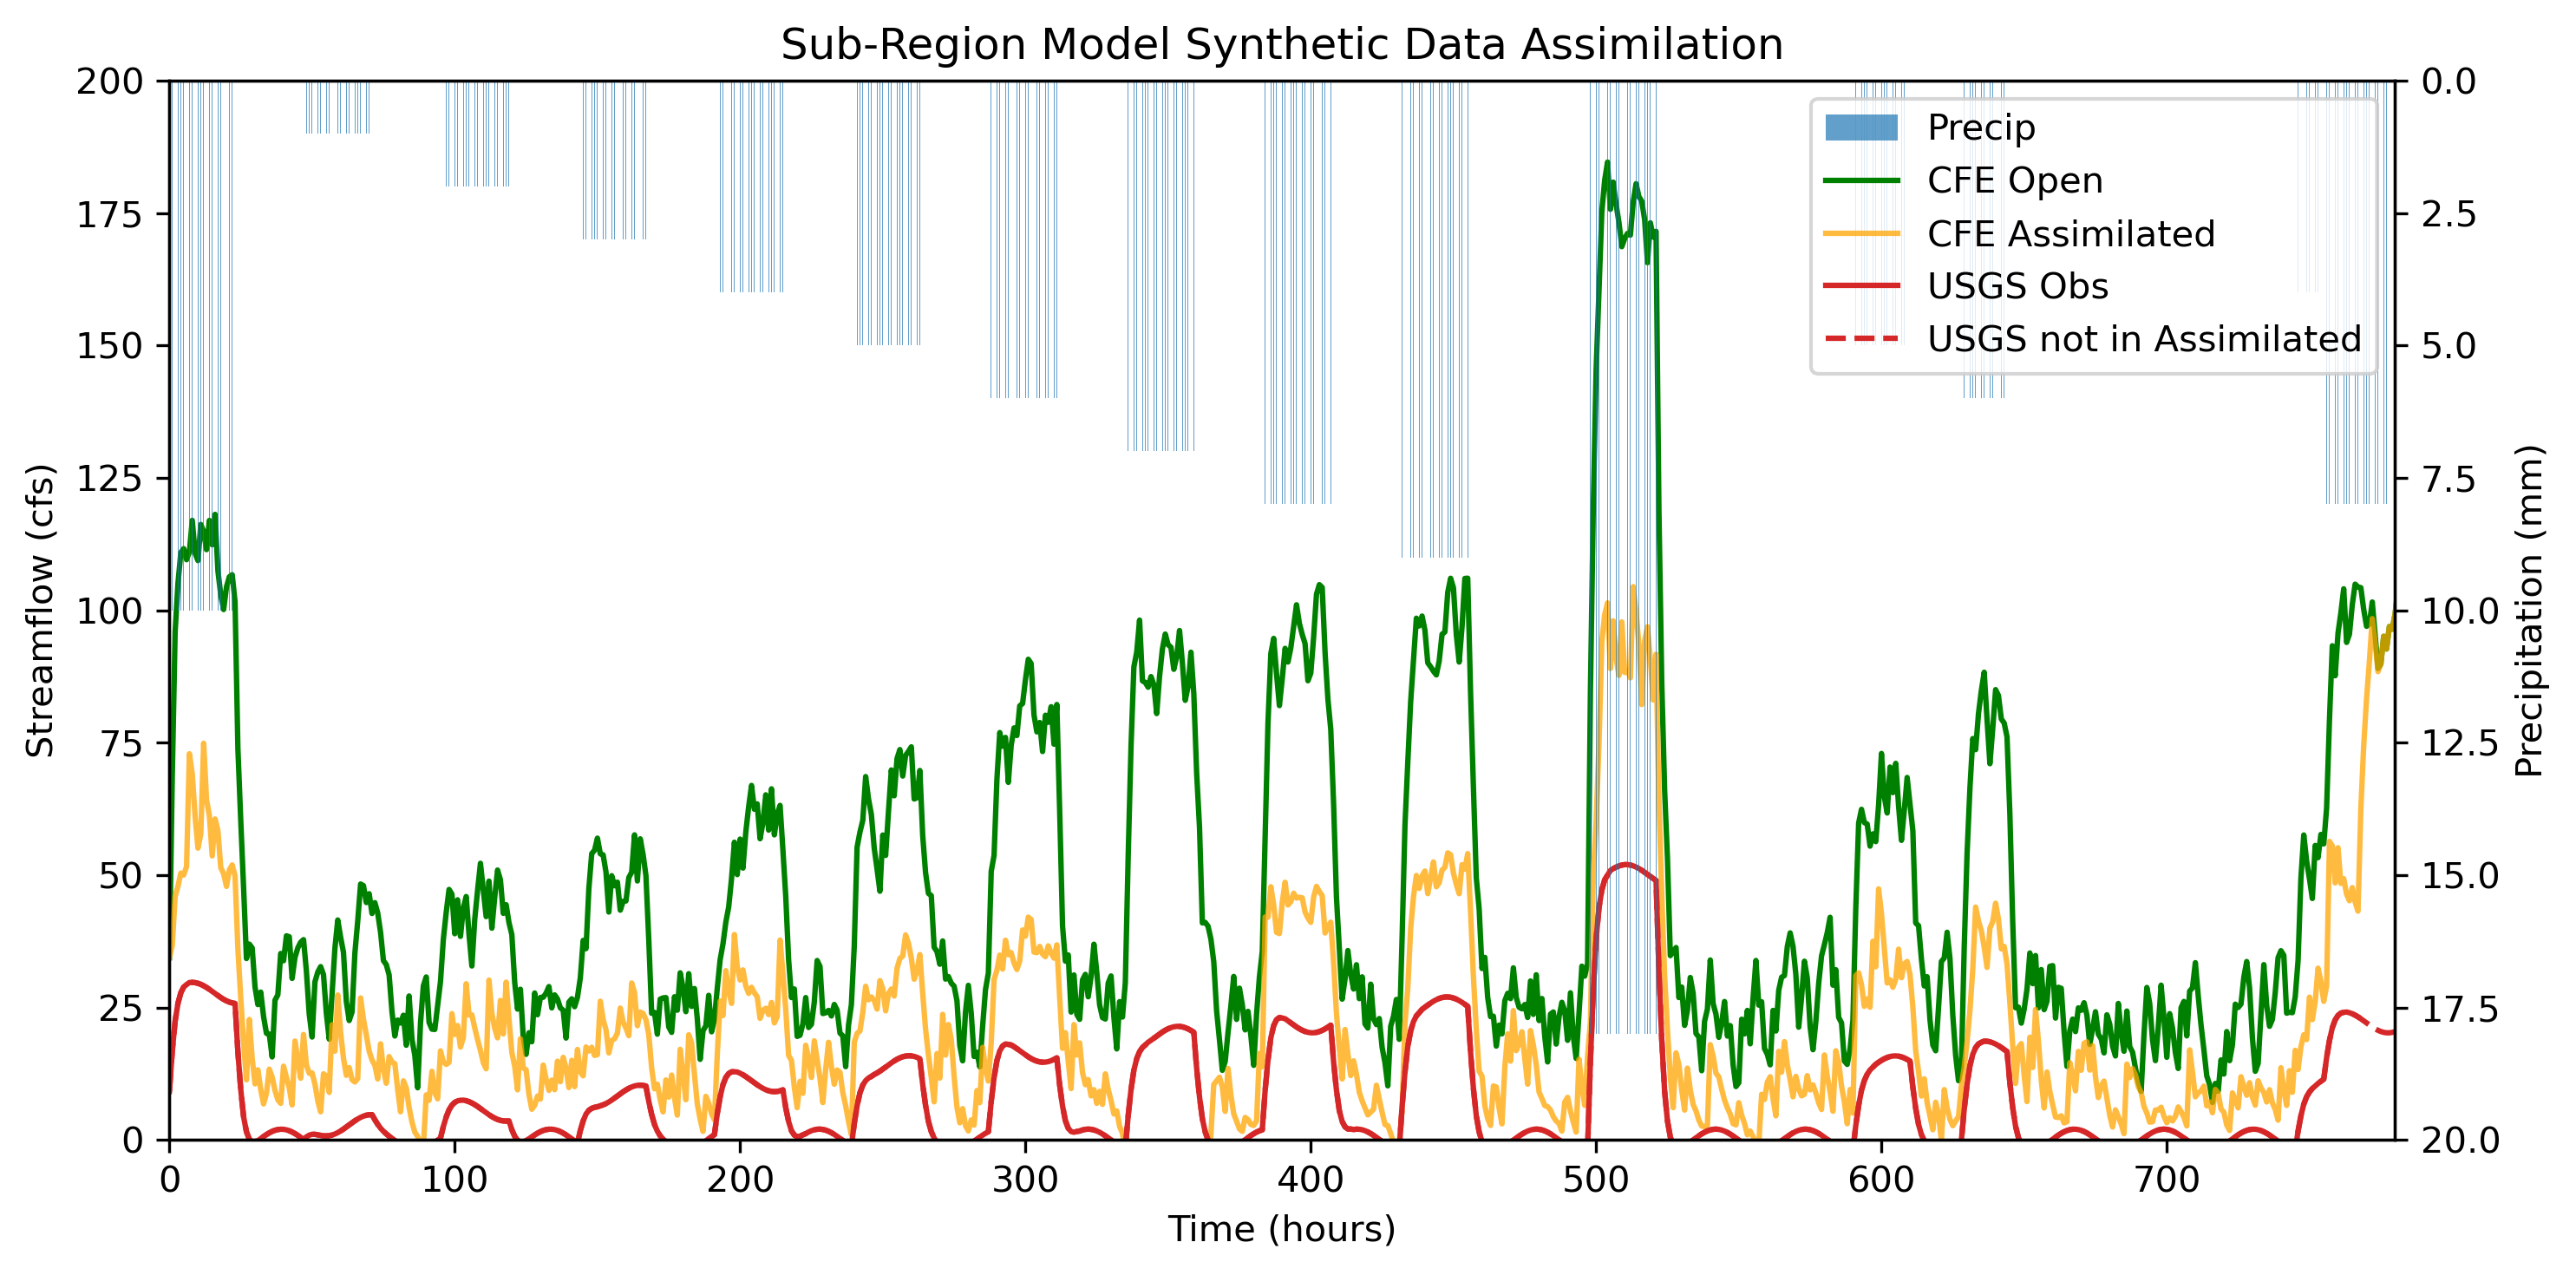

In [5]:
# Define time range for plotting
istart_plot=0
iend_plot=786
x = list(range(istart_plot, iend_plot))

# Set plotting dimensions
fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

# Make double y-axis to plot precipitation on top of of the plot. Set labels and limits for axes
ax2 = ax1.twinx()
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,20,1)
ax2.invert_yaxis()
plt.xlim(0,780)

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Streamflow (cfs)')
ax1.set_ylim(0,200,1)

plt.title('Sub-Region Model Synthetic Data Assimilation')

# Plot the variables on the plot! 
Precip = ax2.bar(x, df_forcing['APCP_surface_0'],width=0.2,alpha=0.7, color="tab:blue", label = 'Precip')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(OBSERVATIONS_LIST[istart_plot:768], color = 'tab:red', label = 'USGS Obs')
Obs2, = ax1.plot(OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS not in Assimilated')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

# Plot the legend and fix layout
plt.legend(handles = [Precip,Open,Analysis,Obs,Obs2], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
fig.tight_layout()
ax1.margins(x=0)

#plt.savefig("WorkingDA_7-19.png")
plt.show()


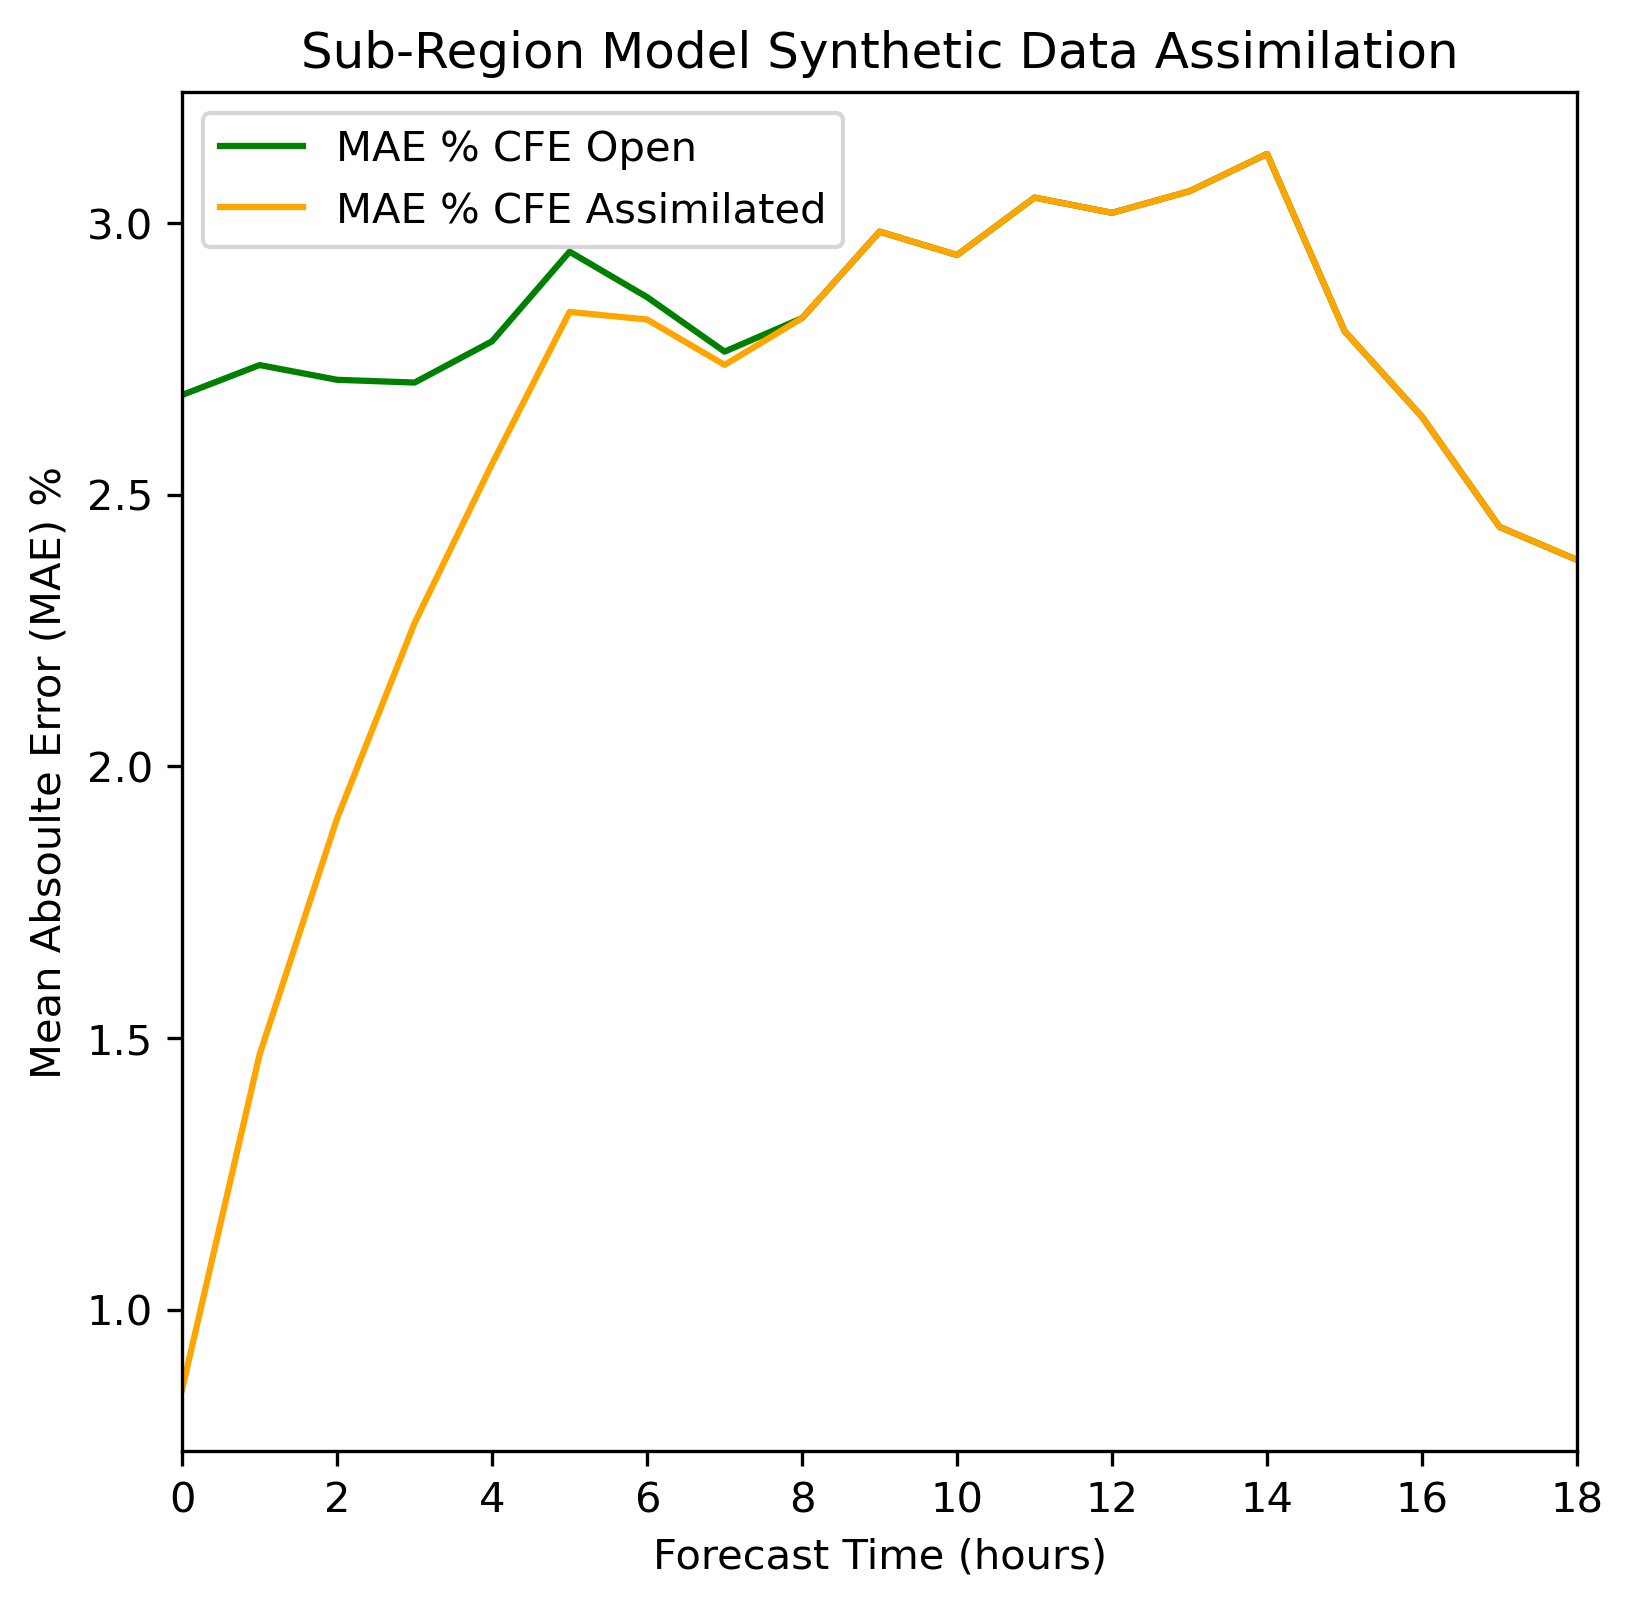

In [6]:
# Plot the Mean Absolute Error (MAE) of CFE Open vs CFE Assimilated
fig = plt.subplots(figsize = (6,6), dpi=300)

# Set labels and limits
plt.title('Sub-Region Model Synthetic Data Assimilation')
plt.xlim(0,18)
plt.xlabel('Forecast Time (hours)')
plt.ylabel('Mean Absoulte Error (MAE) %')

# Plot data
plt.plot(cfeOpen_ensa_mean, color = 'green', label = 'MAE % CFE Open')
plt.plot(cfeanalysis_ensa_mean, color = 'orange', label = 'MAE % CFE Assimilated')

# Show
plt.legend()
plt.show()


In [7]:
# Put values into dataframe to calculate statistics
df = pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True) #drop NaN values
df.reset_index(drop=True, inplace=True) #reset index


# CFE Open Evaluation
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias_open=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("CFE Open Statistics")
print("r_open     =",r_open[0])
print("KGE_open   =",kge_open[0])
print("NSE_open   =", nse_open[0])
print("PBIAS_open =", pbias_open[0])
print("--------------------------")

# CFE Analysis Evaluation
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("CFE Analysis Statistics")
print("r_analysis     =",r_analysis[0])
print("KGE_analysis   =",kge_analysis[0])
print("NSE_analysis   =", nse_analysis[0])
print("PBIAS_analysis =", pbias_analysis[0])
print("--------------------------")

# Mean and Std of Models and Observations
print("Mean and STD of Models and Observations")
print("mean_obs      =",np.mean(df["obs"]))
print("STD_obs       =",np.std(df["obs"]))
print("mean_open     =",np.mean(df["cfeOpen"]))
print("STD_open      =",np.std(df["cfeOpen"]))
print("mean_analysis =",np.mean(df["cfeAnalysis"]))
print("STD_analysis  =",np.std(df["cfeAnalysis"]))

CFE Open Statistics
r_open     = 0.9752711532378185
KGE_open   = -0.0767505289500583
NSE_open   = -0.8777810226868932
PBIAS_open = 84.00853906632571
--------------------------
CFE Analysis Statistics
r_analysis     = 0.7163619160033214
KGE_analysis   = 0.13697054057150515
NSE_analysis   = 0.1751035195239251
PBIAS_analysis = 61.87224119404609
--------------------------
Mean and STD of Models and Observations
mean_obs      = 7.82998928152997
STD_obs       = 11.330467618341043
mean_open     = 48.96356445483878
STD_open      = 34.65822995885161
mean_analysis = 20.53619076164336
STD_analysis  = 24.138943837832628
